In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import norm
from matplotlib import pyplot as plt

# Identification of the parameters $\{p, \phi, \alpha_0, \alpha_1\}$

The model is
$$
\max_{m_i} \frac{(y_i-pm_i)^{1-\sigma}}{1-\sigma} + \phi (1-\exp(-\alpha_1 - \alpha_0 m_i))
$$
The FOC is 
$$
p (y_i-pm_i)^{-\sigma} = \phi\alpha_0 \exp(-\alpha_1 - \alpha_0 m_i)
$$
This gives a solution $m_i = {\cal M}(y_i,p|\sigma, \phi, \alpha_0, \alpha1)$


### US
For the US, we have $p=1$ and $\sum_i \omega_i y_i \equiv y = 1$. Therefore, the moments restrictions  
$$
\Psi_1 = \frac{p \sum_i \omega_i m_i}{\sum_i \omega_i y_i}
$$
$$
\Psi_2 = \sum_i (1-\exp(-\alpha_1 - \alpha_0 m_i))
$$
$$
\Psi_3 = \frac{(1-\exp(-\alpha_1 - \alpha_0 m_{\max}))}{(1-\exp(-\alpha_1 - \alpha_0 m_{\min}))}
$$
allows to identify $\{\phi,\alpha_0,\alpha_1\}$


### Europe

For Europe, we keep $\{\phi,\alpha_0,\alpha_1\}$ found in the previous step, and the moments restrictions
$$
\Psi_1 = \frac{p \sum_i \omega_i m_i}{\sum_i \omega_i y_i}
$$
$$
\Psi_2 = \sum_i (1-\exp(-\alpha_1 - \alpha_0 m_i))
$$
allows to identify $\{p,\alpha_1\}$, given that a calibration of $\sum_i \omega_i y_i \equiv y$



## Functions

In [2]:
#Function for finding the decision rule for m

def medexp(m, *param_m):
    p, y, sigma, alpha0, phi, alpha1 = param_m 
    return p*( (y - p*max(0,min(m,y/p)))**(-sigma) ) - alpha0*phi*np.exp(-( alpha1 + alpha0*max(0,min(m,y/p)) )) 

# Function for finding parameters (alpha0, phi, alpha1) using US moments' restrictions
def hetero_calib(pd_c, *param_c):
    
    Psi1, Psi2, Psi3, p, yy, sigma = param_c 
    
    msolv = np.zeros(yy.size)
    
    for ii in range(yy.size):
        param_cm  = (p, yy[ii], sigma, pd_c[0], pd_c[1], pd_c[2])
        m0        = .1
        msolv[ii] = max(0,fsolve(medexp, m0, args=param_cm))
    
    return [Psi1 - np.mean(msolv), 
            Psi2 - np.mean(1-np.exp(-pd_c[2]-pd_c[0]*msolv)),
            Psi3 - (1-np.exp(-pd_c[2]-pd_c[0]*msolv[-1]))/(1-np.exp(-pd_c[2]-pd_c[0]*msolv[0])) ] 

# Function for finding (p, alpha1) using European moments' restrictions
def hetero_calib_eu(pd_s, *param_s):
    
    Psi1, Psi2, yy, sigma, phi, alpha0 = param_s 
    
    msolv = np.zeros(yy.size)
    
    for ii in range(yy.size):
        param_sm  = (pd_s[0], yy[ii], sigma, alpha0, phi, pd_s[1])
        m0        = .1
        msolv[ii] = max(0,fsolve(medexp, m0, args=param_sm))
    
    return [Psi1 - (pd_s[0]*np.mean(msolv))/(np.mean(yy)), 
            Psi2 - np.mean(1-np.exp(-pd_s[1]-alpha0*msolv))] 

# Function for finding the price, given all other parameters (alpha0, phi, alpha1)
def hetero_new_price(p_new, *param_s):
    
    Psi1, yy, sigma, phi, alpha1, alpha0 = param_s 
    
    msolv = np.zeros(yy.size)
    
    for ii in range(yy.size):
        param_sn  = (p_new, yy[ii], sigma, alpha0, phi, alpha1)
        m0        = .05
        msolv[ii] = max(0,fsolve(medexp, m0, args=param_sn))
    
    return Psi1 - (p_new*np.mean(msolv))/(np.mean(yy)) 

## Calibrated parameter

In [3]:
sigma  = 2.0
Ncount = 2

## Aggregate moments

Health inequalities: we use the gradient for the 4th quartile relative to the first. 

In [4]:
grad_c  = [1.061, 1.276]

GDP share of health expenditures

In [5]:
s_c  = [0.0955, 0.1504]

Income

In [6]:
y_c  = [0.78, 1]

For health status, we use the average health from the ADL definition in Table 4. 

In [7]:
h_c  = [0.931, 0.892]

In [8]:
psi = np.zeros((Ncount,3))
for ii in range(Ncount):
    psi[ii,:] = [s_c[ii],h_c[ii],grad_c[ii]]

psi

array([[0.0955, 0.931 , 1.061 ],
       [0.1504, 0.892 , 1.276 ]])

## Income inequalities: the US

Table 5 gives the variance of the income process. If log income has mean 0 and variance equal to $\sigma^2_{\epsilon}$, we can solve for the quartiles (we use mid-points of quartiles, 12.5, 37.5, 62.5 and 87.5)

We take the mean for EU in Table 5. 

In [9]:
sig_eu  = np.mean([0.256367, 0.094643, 0.214538, 0.237439, 0.169834, 0.094643, 0.270357])
sig_c   = [sig_eu, 0.486429]
sig_c

[0.19111728571428574, 0.486429]

We find the percentiles, transform in levels and normalize to 1. 

In [10]:
qs   = [0.125,0.375,0.625,0.875]
yy_c = np.zeros((Ncount,4))

for ii in range(Ncount):
    yy    = [norm(0,np.sqrt(sig_c[ii])).ppf(q) for q in qs]
    yy    = np.exp(yy)
    yy_c[ii,:] = y_c[ii]*yy/np.mean(yy)


Here are relative incomes. Much more inequality in US

In [11]:
yy_c[-1,-1]/yy_c[-1,0], yy_c[0,-1]/yy_c[0,0]

(4.975918497985015, 2.7340817164336597)

## Solution for the US

In [12]:
param_c   = (psi[1,0], psi[1,1], psi[1,2], 1, yy_c[1], sigma)
pd_c0     = [6 , 2 , 2 ] 
calibsol  = fsolve(hetero_calib, pd_c0, args=param_c) 
calibsol

/Users/francoislangot/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([7.51739835, 3.00535761, 1.46651755])

We check the solution: to find the health gradient with the model 

In [13]:
msolv = np.zeros(yy.size)

for ii in range(yy.size):
    param_m   = (1, yy_c[1,ii], sigma, calibsol[0], calibsol[1], calibsol[2])
    m0        = .1
    msolv[ii] = max(0,fsolve(medexp, m0, args=param_m))

msolv, ( 1-np.exp(-(calibsol[2]+calibsol[0]*msolv[-1])) )/( 1-np.exp(-(calibsol[2]+calibsol[0]*msolv[0])) )

(array([0.        , 0.081768  , 0.18348814, 0.33634386]), 1.2759999999998748)

## Solution for the Europe

In [14]:
param_s           = (psi[0,0], psi[0,1], yy_c[0], sigma, calibsol[1], calibsol[0])
pd_c0             = [0.9 , calibsol[2]]
calibsol_eu       = fsolve(hetero_calib_eu, pd_c0, args=param_s)

In [15]:
calibsol_eu

array([0.56730391, 1.89073796])

## Individual decisions and health gradient: Europe

In [16]:
msolv_eu = np.zeros(yy.size)
for jj in range(yy.size):
    param_m         = (calibsol_eu[0], yy_c[0,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
    m0              = .1
    msolv_eu[jj]    = max(0,fsolve(medexp, m0, args=param_m))
grads_eu = ( 1-np.exp(-(calibsol_eu[1]+calibsol[0]*msolv_eu[-1])) )/(1-np.exp(-(calibsol_eu[1]+calibsol[0]*msolv_eu[0])))
    
msolv_eu, grads_eu


(array([0.01549786, 0.09418598, 0.16101862, 0.25451866]), 1.1294746245585219)

## Demand : price elasticity in the US

In [17]:
msolvp = np.zeros(yy.size)
msolvm = np.zeros(yy.size)

for ii in range(yy.size):
    param_m   = (1.1, yy_c[1,ii], sigma, calibsol[0], calibsol[1], calibsol[2])
    m0        = .1
    msolvp[ii] = max(0,fsolve(medexp, m0, args=param_m))
    param_m   = (0.9, yy_c[1,ii], sigma, calibsol[0], calibsol[1], calibsol[2])
    m0        = .1
    msolvm[ii] = max(0,fsolve(medexp, m0, args=param_m))

dpop    = (1.1-1)/1
level0  = s_c[1]
level1p = np.mean(msolvp)
level1m = np.mean(msolvm)

((level1m-level0)/level0)/dpop, -((level1p-level0)/level0 )/dpop

(0.7497906679729238, 0.6677553518387034)

In [18]:
-(((level1m-level0)/level0)/dpop + (-((level1p-level0)/level0 )/dpop))/2

-0.7087730099058136

## Demand : income elasticity in the US

In [19]:
msolvp = np.zeros(yy.size)
msolvm = np.zeros(yy.size)

for ii in range(yy.size):
    param_m   = (1, 1.1*yy_c[1,ii], sigma, calibsol[0], calibsol[1], calibsol[2])
    m0        = .1
    msolvp[ii] = max(0,fsolve(medexp, m0, args=param_m))
    param_m   = (1, 0.9*yy_c[1,ii], sigma, calibsol[0], calibsol[1], calibsol[2])
    m0        = .1
    msolvm[ii] = max(0,fsolve(medexp, m0, args=param_m))

dyoy    = (1.1-1)/1
level0  = s_c[1]
level1p = np.mean(msolvp)
level1m = np.mean(msolvm)

((level1p-level0)/level0)/dyoy, -((level1m-level0)/level0)/dyoy 

(1.1746605940831996, 1.2636166918805645)

In [20]:
((((level1p-level0)/level0)/dyoy)+(-((level1m-level0)/level0)/dyoy))/2 

1.219138642981882

## Demand : price elasticity in EU

In [21]:
msolv_eup = np.zeros(yy.size)
msolv_eum = np.zeros(yy.size)

for jj in range(yy.size):
    param_m         = (calibsol_eu[0]*1.1, yy_c[0,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
    m0              = .1
    msolv_eup[jj]   = max(0,fsolve(medexp, m0, args=param_m))
    param_m         = (calibsol_eu[0]*0.9, yy_c[0,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
    m0              = .1
    msolv_eum[jj]   = max(0,fsolve(medexp, m0, args=param_m))

level0  = s_c[0]/(calibsol_eu[0]/y_c[0]) 
level1p = np.mean(msolv_eup) 
level1m = np.mean(msolv_eum) 

((level1m-level0)/level0)/dpop, -((level1p-level0)/level0)/dpop 

(1.040449852797365, 0.9226845436459346)

In [22]:
-((((level1m-level0)/level0)/dpop)+(-((level1p-level0)/level0)/dpop))/2

-0.9815671982216497

## Demand : income elasticity in EU

In [23]:
msolv_eup = np.zeros(yy.size)
msolv_eum = np.zeros(yy.size)

for jj in range(yy.size):
    param_m         = (calibsol_eu[0], 1.1*yy_c[0,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
    m0              = .1
    msolv_eup[jj]   = max(0,fsolve(medexp, m0, args=param_m))
    param_m         = (calibsol_eu[0], 0.9*yy_c[0,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
    m0              = .1
    msolv_eum[jj]   = max(0,fsolve(medexp, m0, args=param_m))

level0  = s_c[0]/(calibsol_eu[0]/y_c[0])    
level1p = np.mean(msolv_eup) 
level1m = np.mean(msolv_eum)

((level1p-level0)/level0)/dyoy, -((level1m-level0)/level0)/dyoy 

(1.7356186895066263, 1.7690924707129616)

In [24]:
((((level1p-level0)/level0)/dpop)+(-((level1m-level0)/level0)/dpop))/2

1.752355580109794

# Forecasting of the GDP share of health expenditures

Observation: the shift in GDP per capita

Implication: the implicit shift in healthcare prices

### GDP per capita

GDP share of health expenditures: OECD data

Real GDP per capita: WB data (World Development Indicators)

In [25]:
# 1970
GDPpc_eu70 = [17887.10176179620, 26927.95903692180, 17519.42717022000, 15729.85644157820, 21354.25810368360, 24388.29821013090, 11431.59455874400]
PMoY_eu70  = [5.713, 7.676666666666667,   5.184, float("NAN"), 5.434246479956248,  5.506, 3.145]
GDPpc70    = [np.nanmean(GDPpc_eu70), 25279.18879113590]
PMoY70     = [np.nanmean(PMoY_eu70) , 6.232]
# 1990
GDPpc_eu90 = [29473.85438511120,   39295.24344249190,   28512.10870941340,   27479.57862963770,   31093.54486501490,   34570.30573399390,   18962.44605133250]
PMoY_eu90  = [8.031, 8.038, 7.958, 7.015, 7.082, 7.256, 6.101]
GDPpc90    = [np.nanmean(GDPpc_eu90) , 39278.59534978750]
PMoY90     = [np.nanmean(PMoY_eu90) , 11.273]
# 2000
GDPpc_eu00 = [34476.20802831070, 49241.92800413450, 33583.85744208620, 32337.89674255510, 40440.67534426340, 41117.15243035039, 23928.67165633810]
PMoY_eu00  = [9.827999999999999, 8.103999999999999, 9.541, 7.58, 7.056, 7.412, 6.8160]
GDPpc00 = [np.nanmean(GDPpc_eu00) , 48689.03128985530]
PMoY00  = [np.nanmean(PMoY_eu00) , 12.502]
# 2017
GDPpc_eu10 = [42622.40993268510, 55735.76490114850, 37678.92729753470, 31231.66444646460, 46978.44880120770, 52576.81028210510, 27213.45166906160]
PMoY_eu10  = [11.272, 10.218, 11.458, 8.9010, 10.143, 10.916, 8.840999999999999]
GDPpc10    = [np.nanmean(GDPpc_eu10) , 58387.77580835719]
PMoY10     = [np.nanmean(PMoY_eu10) , 17.149999999999999]


In [26]:
psi0    = [i/100 for i in PMoY90]
psi1    = [i/100 for i in PMoY10]

## Income heterogeneity by country (data)
We rescale the income level and compute the quartiles in 1970 and 2017

In [27]:
y70_c = y_c*np.array(GDPpc70)/np.array(GDPpc00)
y90_c = y_c*np.array(GDPpc90)/np.array(GDPpc00)
y00_c = y_c*np.array(GDPpc00)/np.array(GDPpc00)
y10_c = y_c*np.array(GDPpc10)/np.array(GDPpc00)

yy70_c = np.zeros((Ncount,yy.size))
yy90_c = np.zeros((Ncount,yy.size))
yy00_c = np.zeros((Ncount,yy.size))
yy10_c = np.zeros((Ncount,yy.size))

for ii in range(Ncount):
    yy    = [norm(0,np.sqrt(sig_c[ii])).ppf(q) for q in qs]
    yy    = np.exp(yy)
    yy70_c[ii,:] = y70_c[ii]*yy/np.mean(yy)
    yy90_c[ii,:] = y90_c[ii]*yy/np.mean(yy)
    yy00_c[ii,:] = y00_c[ii]*yy/np.mean(yy)
    yy10_c[ii,:] = y10_c[ii]*yy/np.mean(yy)

In [28]:
prevsol0 = [0,0]
prevsol1 = [0,0]
#                  pm/y     income    sigma  phi          alpha_1         alpha_0
param_s        = (psi0[0], yy90_c[0], sigma, calibsol[1], calibsol_eu[1], calibsol[0])
pd_c0          = .1 #.3
prevsol0[0]    = list(fsolve(hetero_new_price, pd_c0, args=param_s))
param_s        = (psi0[1], yy90_c[1], sigma, calibsol[1], calibsol[2], calibsol[0])
pd_c0          = .8
prevsol0[1]    = list(fsolve(hetero_new_price, pd_c0, args=param_s))

param_s        = (psi1[0], yy10_c[0], sigma, calibsol[1], calibsol_eu[1], calibsol[0])
pd_c0          = .5#.5
prevsol1[0]    = list(fsolve(hetero_new_price, pd_c0, args=param_s))
param_s        = (psi1[1], yy10_c[1], sigma, calibsol[1], calibsol[2], calibsol[0])
pd_c0          = 1.2
prevsol1[1]    = list(fsolve(hetero_new_price, pd_c0, args=param_s))


In [29]:
prevsol0, prevsol1

([[0.23604486640425093], [0.4808111082647214]],
 [[0.5199008531699448], [1.3770087808513378]])

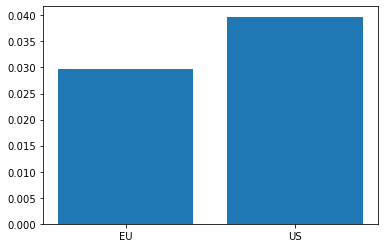

In [30]:
columns = ('EU', 'US')
Price0 = sum(prevsol0,[])
Price1 = sum(prevsol1,[]) 
gPrice = [((Price1[ii]/Price0[ii])**(1/(2017-1990)))-1 for ii in np.arange(len(columns))]
plt.bar(np.arange(len(columns)), gPrice)
plt.xticks(np.arange(len(columns)), labels=columns)
plt.show()

In [31]:
gPrice

[0.029676881213976047, 0.039739460012813366]

### Size of the error when price changes are omitted

If prices change, then the model predicts exactly the GDP share of health expenditures (targeted data)

$\Rightarrow$ If prices do not change, then it exists a gap between model and data: this gap gives the error if price change are neglected 

In [32]:
msolv0_90 = np.zeros((2,yy.size))
pmoys0_90 = [0,0]
msolv0_10 = np.zeros((2,yy.size))
pmoys0_10 = [0,0]


for jj in range(yy.size):
    param_m        = (calibsol_eu[0], yy90_c[0,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
    m0             = .1
    msolv0_90[0,jj]= max(0,fsolve(medexp, m0, args=param_m))
    param_m        = (calibsol_eu[0], yy10_c[0,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
    m0             = .1
    msolv0_10[0,jj]= max(0,fsolve(medexp, m0, args=param_m))

for jj in range(yy.size):
    param_m        = (1, yy90_c[1,jj], sigma, calibsol[0], calibsol[1], calibsol[2])
    m0             = .1
    msolv0_90[1,jj]= max(0,fsolve(medexp, m0, args=param_m))
    param_m        = (1, yy10_c[1,jj], sigma, calibsol[0], calibsol[1], calibsol[2])
    m0             = .1
    msolv0_10[1,jj]= max(0,fsolve(medexp, m0, args=param_m))

price_bench = [calibsol_eu[0],1] 
for ii in range(2):            
    pmoys0_90[ii]= 100*price_bench[ii]*np.mean(msolv0_90[ii,:])/np.mean(yy90_c[ii,:])
    pmoys0_10[ii]= 100*price_bench[ii]*np.mean(msolv0_10[ii,:])/np.mean(yy10_c[ii,:])

pmoys0_90, PMoY90, pmoys0_10, PMoY10

([8.112481459718433, 13.91943187305987],
 [7.3544285714285715, 11.273],
 [10.44032415091521, 15.510530852904944],
 [10.249857142857142, 17.15])

Without price change, the model over-estimate the GDP share of health expenditures in the 1990s

In [33]:
[pmoys0_90[ii]-PMoY90[ii] for ii in np.arange(2)]

[0.7580528882898614, 2.6464318730598695]

Without price changes, the model under-estimate the GDP share of health expenditures in the 2010s for the U.S.

In [34]:
[pmoys0_10[ii]-PMoY10[ii] for ii in np.arange(2)]

[0.19046700805806793, -1.6394691470950544]

# Forcasting long run change in GDP share of Health Expenditures

### Long run changes in GDP per capita and income dispersion

In [35]:
gGDPpc    = [((GDPpc10[ii]/GDPpc90[ii])**(1/(2017-1990))-1) for ii in np.arange(2)]
agGDPpc   = np.array(gGDPpc)
agGDPpc10 = np.array(GDPpc10)

horizon = 4
fGDPpc  = np.zeros((2,horizon))
fy_c    = np.zeros((2,horizon))
fyy_c   = np.zeros((2,horizon,yy.size))

for jj in range(2):
    for ii in range(horizon):
        fGDPpc[jj,ii] = (GDPpc10[jj]*(1+gGDPpc[jj])**(2030+(ii*10)-2017))/GDPpc00[jj]
        fy_c[jj,ii] = y_c[jj]*fGDPpc[jj,ii]
        yy    = [norm(0,np.sqrt(sig_c[jj])).ppf(q) for q in qs]
        yy    = np.exp(yy)
        fyy_c[jj,ii,:] = fy_c[jj,ii]*yy/np.mean(yy)


In [36]:
fGDPpc

array([[1.35719765, 1.53905893, 1.74528919, 1.97915382],
       [1.45139469, 1.68093419, 1.94677557, 2.25466004]])

In [37]:
gGDPpc

[0.01265430880932894, 0.014790792069827585]

### Long run changes in prices

In [38]:
fPrice  = np.zeros((2,horizon))

for jj in range(2):
    for ii in range(horizon):
        fPrice[jj,ii] = (Price1[jj]*(1+gPrice[jj])**(2030+(ii*10)-2017))
        
fPrice

array([[0.76038411, 1.01869143, 1.36474739, 1.82836075],
       [2.28536491, 3.37443308, 4.98248599, 7.35684069]])

Europe with changes in price

In [39]:
xx     = np.zeros((horizon,yy.size))
yy_eu  = np.zeros(horizon)
yy_eu0 = np.zeros(horizon)
yy_us  = np.zeros(horizon)
yy_us0 = np.zeros(horizon)

for ii in range(horizon):
    for jj in range(yy.size):
        param_m          = (fPrice[0,ii], fyy_c[0,ii,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
        m0               = .05#.01
        xx[ii,jj] = max(0,fsolve(medexp, m0, args=param_m)) 
    
    yy_eu[ii] = 100*fPrice[0,ii]*np.mean(xx[ii,:])/np.mean(fyy_c[0,ii,:])


Europe without price changes

In [40]:
for ii in range(horizon):
    for jj in range(yy.size):
        param_m          = (Price1[0], fyy_c[0,ii,jj], sigma, calibsol[0], calibsol[1], calibsol_eu[1])
        m0               = .01#.005
        xx[ii,jj] = max(0,fsolve(medexp, m0, args=param_m)) 
    
    yy_eu0[ii] = 100*Price1[0]*np.mean(xx[ii,:])/np.mean(fyy_c[0,ii,:])


The U.S. with price changes 

In [41]:
for ii in range(horizon):
    for jj in range(yy.size):
        param_m          = (fPrice[1,ii], fyy_c[1,ii,jj], sigma, calibsol[0], calibsol[1], calibsol[2])
        m0               = .01#.005
        xx[ii,jj] = max(0,fsolve(medexp, m0, args=param_m)) 
    
    yy_us[ii] = 100*fPrice[1,ii]*np.mean(xx[ii,:])/np.mean(fyy_c[1,ii,:])


The U.S. without price changes

In [42]:
xx = np.zeros((horizon,yy.size))
for ii in range(horizon):
    for jj in range(yy.size):
        param_m          = (Price1[1], fyy_c[1,ii,jj], sigma, calibsol[0], calibsol[1], calibsol[2])
        m0               = .01#.005
        xx[ii,jj] = max(0,fsolve(medexp, m0, args=param_m)) 
    
    yy_us0[ii] = 100*Price1[1]*np.mean(xx[ii,:])/np.mean(fyy_c[1,ii,:])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


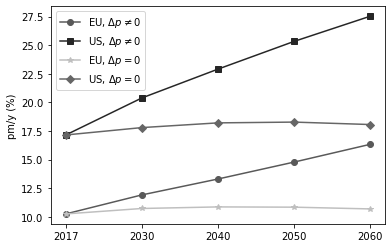

In [43]:
pmoysf       = np.zeros((2,4))
pmoys0f      = np.zeros((2,4))
pmoysf[0,:]  = yy_eu
pmoysf[1,:]  = yy_us
pmoys0f[0,:] = yy_eu0
pmoys0f[1,:] = yy_us0


xx      = np.zeros((2,5))
xx[0,0] = PMoY10[0]
xx[1,0] = PMoY10[-1]
zz      = np.zeros((2,5))
zz[0,0] = PMoY10[0]
zz[1,0] = PMoY10[-1]
for jj in range(2):
    for ii in range(horizon):
        xx[jj,ii+1] = pmoysf[jj,ii] 
        zz[jj,ii+1] = pmoys0f[jj,ii]
    
lyhorizon = ('2017','2030','2040','2050','2060')

plt.plot(np.arange(len(lyhorizon)),list(xx[0,:]),'o-',label=r'EU, $\Delta p \neq 0$',color = '0.35')
plt.plot(np.arange(len(lyhorizon)),list(xx[1,:]),'s-',label=r'US, $\Delta p \neq 0$',color = '0.15')
plt.plot(np.arange(len(lyhorizon)),list(zz[0,:]),'*-',label=r'EU, $\Delta p = 0$',color = '0.75')
plt.plot(np.arange(len(lyhorizon)),list(zz[1,:]),'D-',label=r'US, $\Delta p = 0$',color = '0.4')
plt.xticks(np.arange(len(lyhorizon)), labels=lyhorizon)
plt.legend()
plt.ylabel('pm/y (%)')
plt.savefig('../figures/fig_a2_forecast.eps')
plt.show()